# NFL Big Data Bowl PFF Scouting Data


In [4]:
# Load and preprocess data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report

pff = pd.read_csv('pffScoutingData.csv')
pff = pff.dropna(subset=['pff_sackAllowed'])
features = ['pff_blockType', 'pff_hitAllowed', 'pff_hurryAllowed']
pff = pff.dropna(subset=features)
X = pff[features]
y = pff['pff_sackAllowed']

categorical = X.select_dtypes(include='object').columns.tolist()
numerical = X.select_dtypes(include='number').columns.tolist()
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

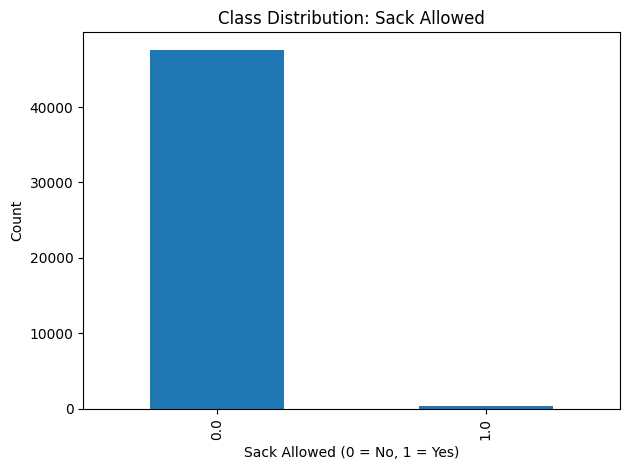

In [11]:
import matplotlib.pyplot as plt

pff['pff_sackAllowed'].value_counts().plot(kind='bar')
plt.title('Class Distribution: Sack Allowed')
plt.xlabel('Sack Allowed (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# Week 1 – Polynomial Logistic Regression


In [5]:

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(preprocessor.fit_transform(X_train))
X_poly_test = poly.transform(preprocessor.transform(X_test))

poly_model = LogisticRegression(max_iter=1000)
poly_model.fit(X_poly, y_train)
poly_preds = poly_model.predict(X_poly_test)

print("Week 1 - Polynomial Logistic Regression Accuracy:", accuracy_score(y_test, poly_preds))
print(classification_report(y_test, poly_preds))


Week 1 - Polynomial Logistic Regression Accuracy: 0.9905020352781547
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9490
         1.0       0.00      0.00      0.00        91

    accuracy                           0.99      9581
   macro avg       0.50      0.50      0.50      9581
weighted avg       0.98      0.99      0.99      9581



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Week 2 – Regularized Regression (RidgeClassifierCV)


In [6]:
# Week 2 – Regularized Regression (RidgeClassifierCV)

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RidgeClassifierCV(alphas=[0.1, 1.0, 10.0]))
])
ridge_pipeline.fit(X_train, y_train)
y_pred = ridge_pipeline.predict(X_test)

print("Week 2 - RidgeClassifierCV Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Week 2 - RidgeClassifierCV Accuracy: 0.9905020352781547
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9490
         1.0       0.00      0.00      0.00        91

    accuracy                           0.99      9581
   macro avg       0.50      0.50      0.50      9581
weighted avg       0.98      0.99      0.99      9581



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
print(ridge_pipeline.named_steps)


{'preprocessor': ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['pff_blockType']),
                                ('num', StandardScaler(),
                                 ['pff_hitAllowed', 'pff_hurryAllowed'])]), 'classifier': RidgeClassifierCV(alphas=[0.1, 1.0, 10.0])}


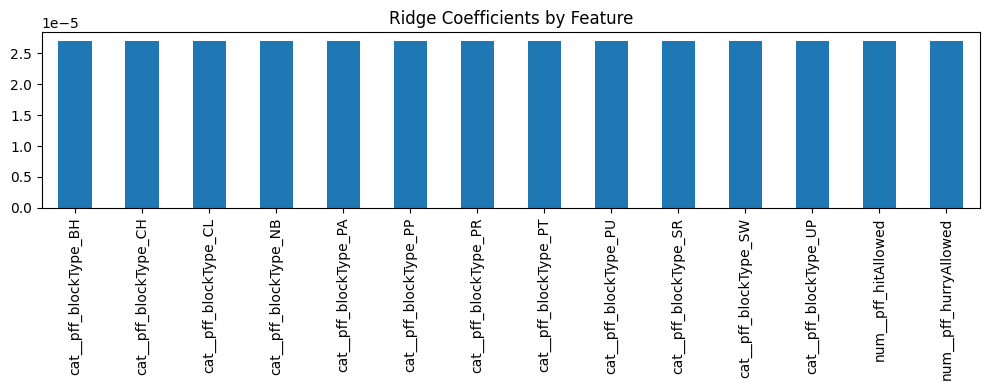

In [15]:
ridge_model = ridge_pipeline.named_steps['classifier']
feature_names = ridge_pipeline.named_steps['preprocessor'].get_feature_names_out()
coef_series = pd.Series(ridge_model.coef_[0], index=feature_names)

coef_series.sort_values(ascending=False).plot(kind='bar', figsize=(10, 4))
plt.title('Ridge Coefficients by Feature')
plt.tight_layout()
plt.show()


# Week 3 – Feature Selection (Stepwise)


In [7]:

from sklearn.feature_selection import SequentialFeatureSelector

stepwise_model = LogisticRegression(max_iter=1000)
sfs = SequentialFeatureSelector(stepwise_model, n_features_to_select=2)
sfs_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('sfs', sfs),
    ('model', stepwise_model)
])
sfs_pipeline.fit(X_train, y_train)
sfs_preds = sfs_pipeline.predict(X_test)

print("Week 3 - Stepwise Feature Selection Accuracy:", accuracy_score(y_test, sfs_preds))
print(classification_report(y_test, sfs_preds))


Week 3 - Stepwise Feature Selection Accuracy: 0.9905020352781547
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9490
         1.0       0.00      0.00      0.00        91

    accuracy                           0.99      9581
   macro avg       0.50      0.50      0.50      9581
weighted avg       0.98      0.99      0.99      9581



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Week 4 – Baseline Logistic Regression


In [8]:

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
logreg_pipeline.fit(X_train, y_train)
logreg_preds = logreg_pipeline.predict(X_test)

print("Week 4 - Logistic Regression Accuracy:", accuracy_score(y_test, logreg_preds))
print(classification_report(y_test, logreg_preds))


Week 4 - Logistic Regression Accuracy: 0.9905020352781547
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9490
         1.0       0.00      0.00      0.00        91

    accuracy                           0.99      9581
   macro avg       0.50      0.50      0.50      9581
weighted avg       0.98      0.99      0.99      9581



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Week 5 – Support Vector Machine


In [9]:

from sklearn.svm import SVC

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear'))
])
svm_pipeline.fit(X_train, y_train)
svm_preds = svm_pipeline.predict(X_test)

print("Week 5 - SVM Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))


Week 5 - SVM Accuracy: 0.9905020352781547
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9490
         1.0       0.00      0.00      0.00        91

    accuracy                           0.99      9581
   macro avg       0.50      0.50      0.50      9581
weighted avg       0.98      0.99      0.99      9581



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Week 6 – Tree-Based Models (Random Forest)


Week 6 - Random Forest Accuracy: 0.9905020352781547
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9490
         1.0       0.00      0.00      0.00        91

    accuracy                           0.99      9581
   macro avg       0.50      0.50      0.50      9581
weighted avg       0.98      0.99      0.99      9581



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


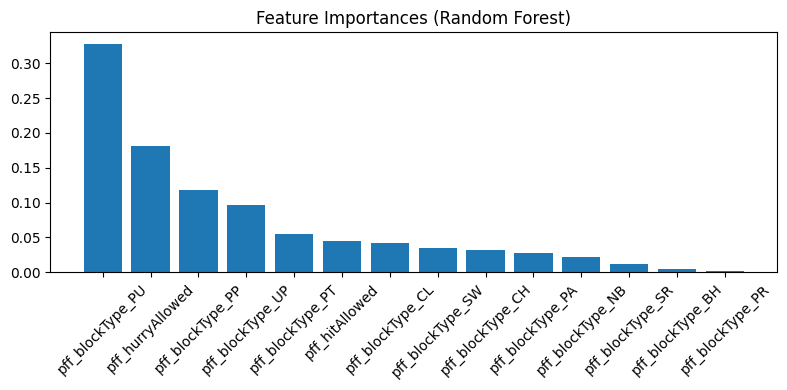

In [10]:

from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=5, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)

print("Week 6 - Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

# Feature importance plot
import matplotlib.pyplot as plt
import numpy as np

rf_model = rf_pipeline.named_steps['classifier']
feature_names = rf_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical).tolist() + numerical
importances = rf_model.feature_importances_

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 4))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()